In [ ]:
!pip install astropy joblib matplotlib numpy scipy scikit-image scikit-learn tqdm umap-learn

# MODEL DEFINITION

In [ ]:
import os
import pickle
from glob import glob

import joblib
import matplotlib.pyplot as plt
import numpy as np
import umap

from astropy.io import fits
from astropy.visualization import ZScaleInterval
from scipy import ndimage
from scipy.signal import find_peaks
from skimage import exposure, feature, filters, measure
from skimage.feature import blob_log
from skimage.measure import moments_hu
from skimage.transform import hough_circle, hough_circle_peaks
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


class AstroClusterModel:
    
    def __init__(self, n_clusters=4, reduction_method='umap', n_components=2):
        """Initialize the model with clustering parameters"""
        self.n_clusters=n_clusters
        self.reduction_method=reduction_method
        self.n_components=n_components
        self.feature_types=['radial', 'blob', 'ring', 'symmetry', 'texture']
        
        self.feature_names=None
        self.scaler=StandardScaler()
        self.reducer=None
        self.kmeans=None
        
        self.labels_=None
        self.reduced_features_=None
        self.interpretations_=None
        self.raw_values_={}
    
    def fit(self, data_dir, viz_output_dir=None, batch_size=5, normalize='zscale'):
        print("Step 1: Loading and preprocessing FITS images...")
        images, filenames=self._process_fits_directory(
            data_dir=data_dir,
            batch_size=batch_size,
            normalize=normalize
        )
        self.filenames_=filenames
        self.images_=images
        
        print("\nStep 2: Extracting features from images...")
        features, feature_names=self._extract_features(images, self.feature_types)
        self.feature_names=feature_names
        self.features_=features
        print(f"Extracted {features.shape[1]} features from each image")
        
        print("\nStep 3: Reducing dimensionality...")
        # Scaling features
        scaled_features=self.scaler.fit_transform(features)
        
        # Applying dimensionality reduction
        if self.reduction_method=='pca':
            self.reducer=PCA(n_components=self.n_components)
        elif self.reduction_method=='umap':
            self.reducer=umap.UMAP(
                n_components=self.n_components,
                n_neighbors=15,
                min_dist=0.1,
                metric='euclidean',
                random_state=42
            )
        
        self.reduced_features_=self.reducer.fit_transform(scaled_features)
        print(f"Reduced features shape: {self.reduced_features_.shape}")
        
        print("\nStep 4: Clustering images...")
        self.kmeans=KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
        self.labels_=self.kmeans.fit_predict(self.reduced_features_)
        
        print("\nStep 5: Interpreting clusters...")
        self.interpretations_, self.raw_values_=self._interpret_clusters(features, feature_names, self.labels_)
        
        # Saving cluster visualizations
        if viz_output_dir:
            print("\nStep 6: Saving cluster visualizations...")
            if not os.path.exists(viz_output_dir):
                os.makedirs(viz_output_dir)
            self._visualize_clusters(
                images=images,
                labels=self.labels_,
                filenames=filenames,
                output_dir=viz_output_dir,
                reduced_features=self.reduced_features_,
                interpretations=self.interpretations_,
                raw_values=self.raw_values_
            )
            
            # Saving cluster summary file
            summary_path=os.path.join(viz_output_dir, 'cluster_summary.txt')
            with open(summary_path, 'w') as f:
                f.write("# Astronomical Image Cluster Summary\n\n")
                for label in np.unique(self.labels_):
                    count=np.sum(self.labels_==label)
                    
                    if label in self.interpretations_:
                        interp_text=" | ".join(self.interpretations_[label])
                        f.write(f"## Cluster {label} ({count} images)\n")
                        f.write(f"**Interpretation**: {interp_text}\n\n")
                    else:
                        f.write(f"## Cluster {label} ({count} images)\n\n")
                    
                    if label in self.raw_values_:
                        f.write("**Feature values**:\n")
                        for key, value in self.raw_values_[label].items():
                            f.write(f"- {key}: {value:.4f}\n")
                        f.write("\n")
                    
                    # List files in this cluster
                    indices=np.where(self.labels_==label)[0]
                    f.write("**Files**:\n")
                    for idx in indices:
                        f.write(f"- {filenames[idx]}\n")
                    f.write("\n\n")
        
        return self
    
    def predict(self, input_dir=None, output_dir=None, images=None, filenames=None, batch_size=5, normalize='zscale'):
        if self.kmeans is None:
            raise ValueError("Model not trained. Call fit() first.")
        
        if input_dir is not None:
            print(f"Processing images from {input_dir}...")
            images, filenames=self._process_fits_directory(
                data_dir=input_dir,
                batch_size=batch_size,
                normalize=normalize
            )
        elif images is None:
            raise ValueError("Either input_dir or images must be provided")
        
        print("Extracting features...")
        features, _=self._extract_features(images, self.feature_types)
        
        print("Predicting clusters...")
        scaled_features=self.scaler.transform(features)
        reduced_features=self.reducer.transform(scaled_features)
        
        # Predict clusters
        labels=self.kmeans.predict(reduced_features)
        
        if output_dir:
            print(f"Saving prediction results to {output_dir}...")
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            
            results_file=os.path.join(output_dir, 'prediction_results.txt')
            with open(results_file, 'w') as f:
                f.write("# Astronomical Image Clustering Predictions\n\n")
                
                f.write("## Summary\n")
                for label in np.unique(labels):
                    count=np.sum(labels==label)
                    if label in self.interpretations_:
                        interp_text=" | ".join(self.interpretations_[label])
                        f.write(f"- Cluster {label}: {count} images - {interp_text}\n")
                    else:
                        f.write(f"- Cluster {label}: {count} images\n")
                f.write("\n")
                
                f.write("## Image Classifications\n")
                for i, (filename, label) in enumerate(zip(filenames, labels)):
                    interp=""
                    if label in self.interpretations_:
                        interp=" - " + " | ".join(self.interpretations_[label])
                    f.write(f"{i+1}. {filename}: Cluster {label}{interp}\n")
            
            self._visualize_clusters(
                images=images,
                labels=labels,
                filenames=filenames,
                output_dir=output_dir,
                reduced_features=reduced_features,
                interpretations=self.interpretations_,
                raw_values=self.raw_values_
            )
        
        return labels, images, filenames
    
    def save(self, model_dir):
        """Save the trained model"""
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        
        joblib.dump(self.scaler, os.path.join(model_dir, 'scaler.pkl'))
        joblib.dump(self.reducer, os.path.join(model_dir, 'reducer.pkl'))
        joblib.dump(self.kmeans, os.path.join(model_dir, 'kmeans.pkl'))
        
        model_params={
            'n_clusters': self.n_clusters,
            'reduction_method': self.reduction_method,
            'n_components': self.n_components,
            'feature_types': self.feature_types,
            'feature_names': self.feature_names,
            'interpretations': self.interpretations_,
            'raw_values': self.raw_values_
        }
        
        with open(os.path.join(model_dir, 'model_params.pkl'), 'wb') as f:
            pickle.dump(model_params, f)
            
        print(f"Model saved to {model_dir}")
    
    @classmethod
    def load(cls, model_dir):
        """Load a trained model"""
        with open(os.path.join(model_dir, 'model_params.pkl'), 'rb') as f:
            model_params=pickle.load(f)
        
        model=cls(
            n_clusters=model_params['n_clusters'],
            reduction_method=model_params['reduction_method'],
            n_components=model_params['n_components']
        )
        
        model.scaler=joblib.load(os.path.join(model_dir, 'scaler.pkl'))
        model.reducer=joblib.load(os.path.join(model_dir, 'reducer.pkl'))
        model.kmeans=joblib.load(os.path.join(model_dir, 'kmeans.pkl'))
        
        model.feature_types=model_params['feature_types']
        model.feature_names=model_params['feature_names']
        model.interpretations_=model_params['interpretations']
        model.raw_values_=model_params['raw_values']
        
        return model
    
    def _process_fits_directory(self, data_dir, batch_size=5, normalize='zscale', smooth=False, sigma=1.0):
        """Process FITS files"""
        fits_files=glob(os.path.join(data_dir, '*.fits'))
        print(f"Found {len(fits_files)} FITS files")
        
        zscale=ZScaleInterval()
        all_data=[]
        all_filenames=[]
        
        for i in tqdm(range(0, len(fits_files), batch_size), desc="Processing batches"):
            batch_files=fits_files[i:i+batch_size]
            batch_data=[]
            batch_filenames=[]
            
            for file_path in batch_files:
                try:
                    with fits.open(file_path) as hdul:
                        image_data=hdul[0].data
                        
                        if image_data.ndim > 2:
                            while image_data.ndim > 2:
                                image_data=image_data[0]
                        
                        image_data=np.nan_to_num(image_data)
                        
                        if normalize=='zscale':
                            image_data=zscale(image_data)
                            min_val=np.min(image_data)
                            max_val=np.max(image_data)
                            if max_val > min_val:
                                image_data=(image_data - min_val) / (max_val - min_val)
                        
                        file_name=os.path.basename(file_path)
                        batch_data.append(image_data)
                        batch_filenames.append(file_name)
                        
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
            
            if batch_data:
                batch_data=[np.array(img) for img in batch_data]
                
                if len(set([img.shape for img in batch_data])) > 1:
                    uniform_size=(600, 600)
                    resized_batch=[]
                    for img in batch_data:
                        zoom_factors=(uniform_size[0]/img.shape[0], uniform_size[1]/img.shape[1])
                        resized=ndimage.zoom(img, zoom_factors, order=1)
                        resized_batch.append(resized)
                    batch_data=resized_batch
                
                all_data.extend(batch_data)
                all_filenames.extend(batch_filenames)
        
        if not all_data:
            raise ValueError("No valid 2D images were processed")
        
        processed_data=np.array(all_data)
        print(f"Processed {len(processed_data)} images, shape: {processed_data.shape}")
        
        return processed_data, np.array(all_filenames)
    
    def _extract_features(self, images, feature_types):
        """Extract features from images"""
        features_list=[]
        feature_names=[]  # To track feature meanings
        
        for img in tqdm(images, desc="Extracting features"):
            if img.ndim != 2:
                raise ValueError(f"Expected 2D image, got shape {img.shape}")
            
            img_features=[]
            current_feature_names=[]
            
            # Radial profile - for detecting rings - circular structures
            if 'radial' in feature_types:
                # Find image center
                center_y, center_x=np.unravel_index(np.argmax(img), img.shape)
                
                use_weighted_center=True
                if use_weighted_center:
                    y, x=np.indices(img.shape)
                    total_intensity=np.sum(img)
                    if total_intensity > 0:
                        center_y=np.sum(y*img)/total_intensity
                        center_x=np.sum(x*img)/total_intensity
                
                y, x=np.indices(img.shape)
                r=np.sqrt((x-center_x)**2 + (y-center_y)**2)
                r=r.astype(int)
                
                max_radius=min(img.shape)//2
                radial_profile=np.zeros(max_radius)
                radial_std=np.zeros(max_radius)  # std to detect rings
                
                for i in range(max_radius):
                    mask=r==i
                    if mask.sum() > 0:
                        radial_profile[i]=img[mask].mean()
                        radial_std[i]=img[mask].std()
                
                if np.max(radial_profile) > 0:
                    radial_profile=radial_profile / np.max(radial_profile)
                if np.max(radial_std) > 0:
                    radial_std=radial_std / np.max(radial_std)
                
                indices=np.linspace(0, len(radial_profile)-1, 20, dtype=int)
                img_features.extend(radial_profile[indices])
                img_features.extend(radial_std[indices])  # Standard deviation helps detect rings
                current_feature_names.extend([f'radial_mean_{i}' for i in range(20)])
                current_feature_names.extend([f'radial_std_{i}' for i in range(20)])
                
                # Rings appear as peaks in derivative of radial profile
                radial_derivative=np.gradient(radial_profile)

                # Counting sign changes in derivative (ring edges)
                sign_changes=np.sum(np.diff(np.signbit(radial_derivative))!=0)
                img_features.append(sign_changes)
                current_feature_names.append('radial_sign_changes')
                
                # Add peak count in radial profile (corresponds to rings)
                peaks, _=find_peaks(radial_profile, height=0.2, distance=3)
                img_features.append(len(peaks))
                current_feature_names.append('ring_count')
            
            # Blob detection - for planet blobs
            if 'blob' in feature_types:
                # Use Laplacian of Gaussian

                img_blob=exposure.equalize_hist(img)
                
                # Detecting blobs at multiple scales
                blobs=blob_log(img_blob, max_sigma=30, num_sigma=10, threshold=.1)
                
                num_blobs=len(blobs)
                img_features.append(num_blobs)
                current_feature_names.append('num_blobs')
                
                if num_blobs > 0:
                    blob_sizes=blobs[:, 2]  # sigma column
                    blob_intensities=np.array([img[int(y), int(x)] for y, x, _ in blobs])
                    
                    img_features.extend([
                        np.mean(blob_sizes),
                        np.std(blob_sizes),
                        np.max(blob_sizes),
                        np.mean(blob_intensities),
                        np.std(blob_intensities)
                    ])
                    current_feature_names.extend([
                        'blob_mean_size', 'blob_std_size', 'blob_max_size',
                        'blob_mean_intensity', 'blob_std_intensity'
                    ])
                else:
                    img_features.extend([0, 0, 0, 0, 0])  # No blobs
                    current_feature_names.extend([
                        'blob_mean_size', 'blob_std_size', 'blob_max_size',
                        'blob_mean_intensity', 'blob_std_intensity'
                    ])
            
            # Ring detection 
            if 'ring' in feature_types:
                edges=feature.canny(img, sigma=2)
                circle_features=[]
                radii=np.arange(10, min(img.shape) // 2, 10)
                
                if len(radii) < 2:
                    radii=np.arange(5, min(img.shape) // 2, 5)
                
                hough_res=hough_circle(edges, radii)
                
                accums, cx, cy, detected_radii=hough_circle_peaks(
                    hough_res, radii, total_num_peaks=5)
                
                img_features.append(len(detected_radii))
                current_feature_names.append('hough_ring_count')
                
                if len(detected_radii) > 0:
                    img_features.append(np.mean(detected_radii))
                    img_features.append(np.std(detected_radii))
                    current_feature_names.extend(['hough_ring_mean_radius', 'hough_ring_std_radius'])
                    
                    # Concentricity - how centered the circles are
                    center_y, center_x=img.shape[0]//2, img.shape[1]//2
                    distances=np.sqrt((cx - center_x)**2 + (cy - center_y)**2)
                    img_features.append(np.mean(distances))
                    current_feature_names.append('hough_ring_center_distance')
                else:
                    img_features.extend([0, 0, 0])  # No rings
                    current_feature_names.extend([
                        'hough_ring_mean_radius', 'hough_ring_std_radius', 'hough_ring_center_distance'
                    ])
                        
            features_list.append(img_features)
            
            if len(feature_names)==0:
                feature_names=current_feature_names
        
        feature_matrix=np.array(features_list)
        return np.nan_to_num(feature_matrix), feature_names
    
    def _interpret_clusters(self, features, feature_names, labels):
        """human-readable interpretations for each cluster"""
        unique_labels=np.unique(labels)
        interpretations={}
        raw_values={}
        
        for label in unique_labels:
            if label==-1:  # Skip noise points
                continue
                
            cluster_features=features[labels==label]
            other_features=features[labels != label]
            
            cluster_means=np.mean(cluster_features, axis=0)
            other_means=np.mean(other_features, axis=0)
            
            description=[]
            raw_values[label]={}
            
            # Planet blobs - adjusted to account for central blob - since central blob is not a planet
            if 'num_blobs' in feature_names and 'blob_mean_size' in feature_names:
                blob_idx=feature_names.index('num_blobs')
                size_idx=feature_names.index('blob_mean_size')
                num_blobs=cluster_means[blob_idx]
                mean_size=cluster_means[size_idx]
                
                # Store raw values
                raw_values[label]['num_blobs']=num_blobs
                raw_values[label]['blob_mean_size']=mean_size
                
                # Adjusted interpretation: subtract 1 for the central blob if generally large blobs
                effective_planets=max(0, num_blobs - 1) if mean_size > 15 else num_blobs
                
                if effective_planets < 0.5:
                    description.append("No planetary bodies")
                elif effective_planets < 1.5:
                    description.append("Single planetary body")
                else:
                    description.append(f"Multiple planetary bodies ({effective_planets:.1f})")
                    
            # Ring structures
            if 'ring_count' in feature_names:
                ring_idx=feature_names.index('ring_count')
                ring_count=cluster_means[ring_idx]-1 # adjustment for central hole
                
                # Store raw values
                raw_values[label]['ring_count'] = ring_count
                
                if ring_count < 1:  # based on experimentation with different thresholds
                    description.append("Simple disc (no rings)")
                elif ring_count > 3:
                    description.append(f"Multiple ring structures ({ring_count:.1f})")
                elif ring_count > 2:
                    description.append(f"Prominent gap or cavity")
                elif ring_count > 1:
                    description.append(f"Possible ring structure ({ring_count:.1f})")
            
            interpretations[label]=description
            
        return interpretations, raw_values
    
    def _visualize_clusters(self, images, labels, filenames, output_dir=None, 
                           reduced_features=None, interpretations=None, raw_values=None):
        """Visualize clustering results with raw values."""
        unique_labels=np.unique(labels)
        
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # Plot cluster distribution
        plt.figure(figsize=(12, 6))
        cluster_counts=np.array([np.sum(labels==label) for label in unique_labels])
        cluster_labels=[f"Cluster {label}" for label in unique_labels]
        
        plt.bar(cluster_labels, cluster_counts)
        plt.title('Distribution of Clusters')
        plt.xlabel('Cluster')
        plt.ylabel('Number of Images')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        if output_dir:
            plt.savefig(os.path.join(output_dir, 'cluster_distribution.png'), dpi=300, bbox_inches='tight')
        
        plt.tight_layout()
        plt.close()  
        
        if reduced_features is not None and reduced_features.shape[1] >= 2:
            plt.figure(figsize=(12, 10))
            
            x, y=reduced_features[:, 0], reduced_features[:, 1]
            
            for label in unique_labels:
                mask=labels==label
                label_str="Noise" if label==-1 else f"Cluster {label}"
                plt.scatter(x[mask], y[mask], label=label_str, s=50, alpha=0.7)
            
            plt.title('2D Visualization of Clusters')
            plt.xlabel('Dimension 1')
            plt.ylabel('Dimension 2')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            if output_dir:
                plt.savefig(os.path.join(output_dir, 'cluster_2d_visualization.png'), 
                           dpi=300, bbox_inches='tight')
            
            plt.close()  
        
        for label in unique_labels:
            indices=np.where(labels==label)[0]
            n_samples=len(indices)
            
            if n_samples==0:
                continue
            
            n_cols=min(n_samples, 8)
            n_rows=(n_samples + n_cols - 1) // n_cols
            
            plt.figure(figsize=(15, 3 * n_rows))
            
            cluster_name="Noise Points" if label==-1 else f"Cluster {label}"
            
            title_text=f"{cluster_name} ({len(indices)} images)"
            if interpretations and label in interpretations:
                interp_text=" | ".join(interpretations[label])
                title_text=f"{title_text}: {interp_text}"
            
            raw_value_text=""
            if raw_values and label in raw_values:
                raw_value_parts=[]
                
                if 'num_blobs' in raw_values[label]:
                    raw_value_parts.append(f"Blob count: {raw_values[label]['num_blobs']:.1f}")
                if 'ring_count' in raw_values[label]:
                    raw_value_parts.append(f"Ring count: {raw_values[label]['ring_count']:.1f}")
                    
                if raw_value_parts:
                    raw_value_text=f"\nRaw values: {' | '.join(raw_value_parts)}"
            
            plt.suptitle(f"{title_text}{raw_value_text}", fontsize=16)
            
            for j, idx in enumerate(indices):
                plt.subplot(n_rows, n_cols, j + 1)
                plt.imshow(images[idx], cmap='viridis')
                plt.title(f"{filenames[idx]}", fontsize=8)
                plt.axis('off')
            
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            
            if output_dir:
                plt.savefig(os.path.join(output_dir, f'cluster_{label}_samples.png'), 
                           dpi=300, bbox_inches='tight')
            
            plt.close()  
        
        if output_dir:
            with open(os.path.join(output_dir, 'cluster_membership.txt'), 'w') as f:
                for label in unique_labels:
                    indices=np.where(labels==label)[0]
                    label_name="Noise" if label==-1 else f"Cluster {label}"
                    
                    if interpretations and label in interpretations:
                        interp_text=" | ".join(interpretations[label])
                        f.write(f"{label_name} ({len(indices)} images): {interp_text}\n")
                    else:
                        f.write(f"{label_name} ({len(indices)} images):\n")
                    
                    if raw_values and label in raw_values:
                        f.write("  Raw values:\n")
                        for key, value in raw_values[label].items():
                            f.write(f"    {key}: {value:.4f}\n")
                        f.write("\n")
                        
                    for idx in indices:
                        f.write(f"  {filenames[idx]}\n")
                    f.write("\n")

# Training Cell
Run after class definition

Initializing and training model...
Step 1: Loading and preprocessing FITS images...
Found 87 FITS files


Processing batches: 100%|██████████| 18/18 [00:01<00:00, 13.46it/s]


Processed 87 images, shape: (87, 600, 600)

Step 2: Extracting features from images...


Extracting features: 100%|██████████| 87/87 [06:20<00:00,  4.38s/it]
c:\Users\aryan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\aryan\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Extracted 52 features from each image

Step 3: Reducing dimensionality...
Reduced features shape: (87, 2)

Step 4: Clustering images...

Step 5: Interpreting clusters...

Step 6: Saving cluster visualizations...
Model saved to saved_model
Model saved to saved_model

Training Results:

Cluster 0:
Interpretations: Multiple planetary bodies (17.8) | Multiple ring structures (5.8)
Raw values:
  num_blobs: 17.8400
  blob_mean_size: 8.2546
  ring_count: 5.8400

Cluster 1:
Interpretations: Single planetary body | Multiple ring structures (3.0)
Raw values:
  num_blobs: 1.1951
  blob_mean_size: 4.3046
  ring_count: 3.0488

Cluster 2:
Interpretations: Multiple planetary bodies (6.7) | Multiple ring structures (9.8)
Raw values:
  num_blobs: 7.7143
  blob_mean_size: 19.8660
  ring_count: 9.7619


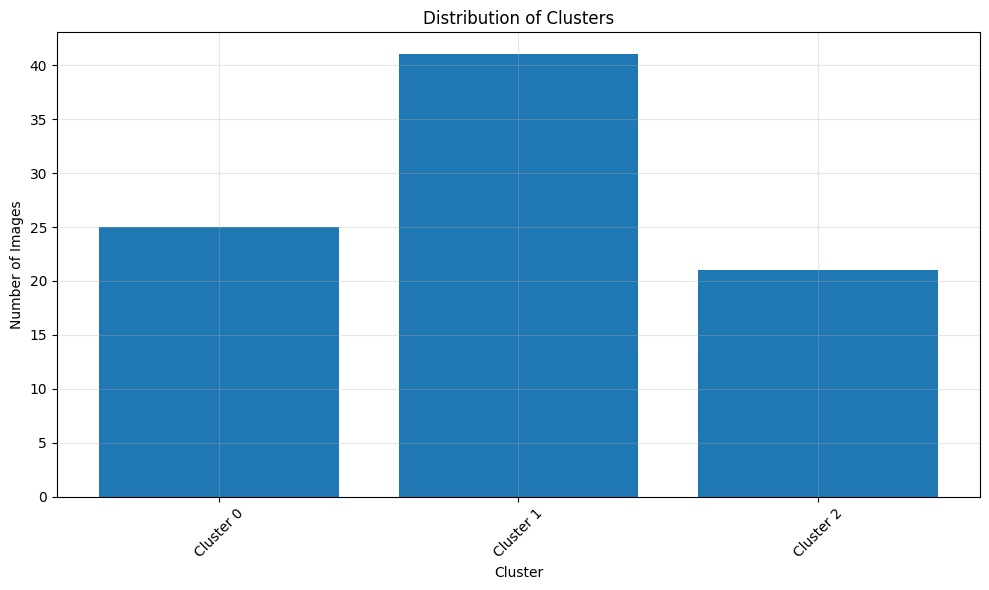

In [60]:
TRAINING_CONFIG={
    'data_dir': 'data',        # dir for training FITS files
    'output_dir': 'output',    # dir for visualizations and results
    'model_save_dir': 'saved_model',     # dir to save the trained model
    'n_clusters': 3,                       # num of clusters
    'reduction_method': 'umap',            # dim red. method ('umap' or 'pca')
    'n_components': 2,                     # num. of dims after reduction
    'batch_size': 5                        # Batch size
}

os.makedirs(TRAINING_CONFIG['output_dir'], exist_ok=True)
os.makedirs(TRAINING_CONFIG['model_save_dir'], exist_ok=True)

try:
    print("Initializing and training model...")
    model=AstroClusterModel(
        n_clusters=TRAINING_CONFIG['n_clusters'],
        reduction_method=TRAINING_CONFIG['reduction_method'],
        n_components=TRAINING_CONFIG['n_components']
    )

    model.fit(
        data_dir=TRAINING_CONFIG['data_dir'],
        viz_output_dir=TRAINING_CONFIG['output_dir'],
        batch_size=TRAINING_CONFIG['batch_size']
    )

    model.save(TRAINING_CONFIG['model_save_dir'])
    print(f"Model saved to {TRAINING_CONFIG['model_save_dir']}")

    print("\nTraining Results:")
    for label in range(TRAINING_CONFIG['n_clusters']):
        print(f"\nCluster {label}:")
        if label in model.interpretations_:
            print("Interpretations:", " | ".join(model.interpretations_[label]))
        if label in model.raw_values_:
            print("Raw values:")
            for key, value in model.raw_values_[label].items():
                print(f"  {key}: {value:.4f}")

    plt.figure(figsize=(10, 6))
    unique_labels, counts=np.unique(model.labels_, return_counts=True)
    plt.bar([f'Cluster {l}' for l in unique_labels], counts)
    plt.title('Distribution of Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error during training: {str(e)}")

# TESTING

Running prediction on test data in test_data...
Processing images from test_data...
Found 13 FITS files


Processing batches:   0%|          | 0/3 [00:00<?, ?it/s]

Processing batches: 100%|██████████| 3/3 [00:00<00:00, 11.45it/s]


Processed 13 images, shape: (13, 600, 600)
Extracting features...


Extracting features: 100%|██████████| 13/13 [01:06<00:00,  5.15s/it]
c:\Users\aryan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Predicting clusters...
Saving prediction results to test_output...

Clustering Results:

Cluster 0 (4 images):
Interpretations: Multiple planetary bodies (17.8) | Multiple ring structures (5.8)
Raw values:
  num_blobs: 17.8400
  blob_mean_size: 8.2546
  ring_count: 5.8400

Cluster 1 (5 images):
Interpretations: Single planetary body | Multiple ring structures (3.0)
Raw values:
  num_blobs: 1.1951
  blob_mean_size: 4.3046
  ring_count: 3.0488

Cluster 2 (4 images):
Interpretations: Multiple planetary bodies (6.7) | Multiple ring structures (9.8)
Raw values:
  num_blobs: 7.7143
  blob_mean_size: 19.8660
  ring_count: 9.7619


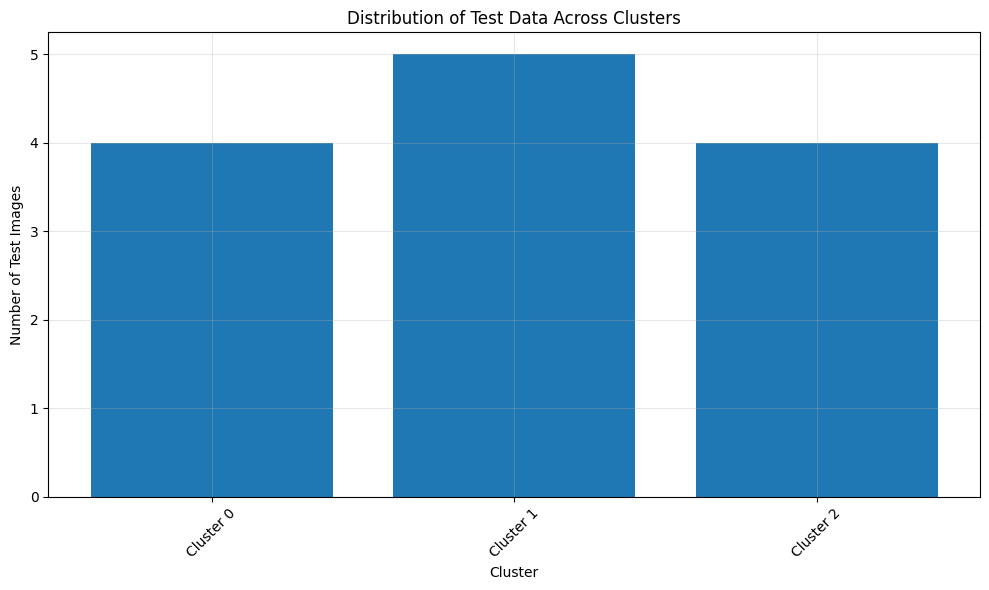

In [61]:
# Load saved model
model=AstroClusterModel.load(TRAINING_CONFIG['model_save_dir'])

TEST_CONFIG={
    'data_dir': 'test_data',    # dir with test FITS files
    'output_dir': 'test_output', # directory for test visuals and results
    'batch_size': 5              # batch size
}

os.makedirs(TEST_CONFIG['output_dir'], exist_ok=True)

# Run prediction on test data
try:
    print(f"Running prediction on test data in {TEST_CONFIG['data_dir']}...")
    
    # Predict clusters for test data
    labels, images, filenames=model.predict(
        input_dir=TEST_CONFIG['data_dir'],
        output_dir=TEST_CONFIG['output_dir'],
        batch_size=TEST_CONFIG['batch_size']
    )
    
    print("\nClustering Results:")
    for label in np.unique(labels):
        count=np.sum(labels==label)
        print(f"\nCluster {label} ({count} images):")
        if label in model.interpretations_:
            print("Interpretations:", " | ".join(model.interpretations_[label]))
        if label in model.raw_values_:
            print("Raw values:")
            for key, value in model.raw_values_[label].items():
                print(f"  {key}: {value:.4f}")
    
    # Plot cluster distribution for test data
    plt.figure(figsize=(10, 6))
    test_unique_labels, test_counts=np.unique(labels, return_counts=True)
    plt.bar([f'Cluster {l}' for l in test_unique_labels], test_counts)
    plt.title('Distribution of Test Data Across Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Test Images')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error during testing: {str(e)}")